# Walkthrough Implementation of Transformer for Image Captioning task

Given an image like the example below, our goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

To accomplish this, we'll use a transformer enocder-decoder model, which enables us to see what parts of the image the model focuses on as it generates a caption.


The model architecture is similar to [Attention Is All You Need](https://arxiv.org/abs/1706.03762).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [1]:
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

## Download and Prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train our model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [ ]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)
else:
  annotation_file = os.path.abspath('.') + '/annotations/captions_train2014.json'

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 400s 0us/step


We will use of a subset of 30,000 captions

In [ ]:
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [ ]:
len(train_captions), len(all_captions)

(30000, 414113)

### Preprocess the images using InceptionV3

In [2]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

Now we'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is 8x8x2048.

In [3]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 0s 0us/step


In [ ]:
!pip install tqdm

We will pre-process each image with InceptionV3 and cache the output to disk and image features are reshaped to 64x2048

In [ ]:
# Get unique images
from tqdm import tqdm
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

1622it [06:53,  3.92it/s]


### Preprocess and tokenize the captions

In [4]:
top_k = 5000

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
cap_vector.shape

(30000, 49)

### Split the data into training and testing

In [ ]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

### Create a tf.data dataset for training

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE

In [ ]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Transformer Model



*   We extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
*  We squash that to a shape of (64, 2048).
*  Then it is passed thorugh Encoder which use dense layer to reduce feature size to 512 then add 2d Positional encoding and pass through it multiple self-attention and feed forward layer
* Then Decoder uses predicted caption and encoder output to generate next word in caption



### Positional encoding for 2d and 1d input

for 1d positional enocding

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

for 2d encoding, first d_model/2 represents row position and second d_model/2 units represent column position

In [5]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [6]:
def positional_encoding_1d(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

In [7]:
def positional_encoding_2d(row,col,d_model):
  assert d_model % 2 == 0
  # first d_model/2 encode row embedding and second d_model/2 encode column embedding
  row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
  col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)
  angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
  #apply sin and cos to odd and even indices resp.
  angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
  angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
  angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
  angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
  pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)


Visualizing 2d and 1d positional enocding

(1, 64, 512)


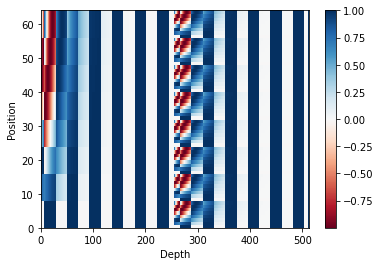

In [ ]:
pos_encoding = positional_encoding_2d(8,8, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

(1, 64, 512)


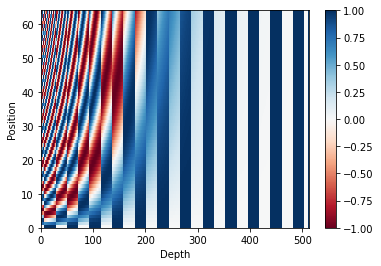

In [ ]:
pos_encoding = positional_encoding_1d(64, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Masking




Mask all the pad token in inputs

In [8]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

look ahead mask used to mask out all values in right of token such that to predict third word only first two words are used

In [9]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

### Scaled dot product attention

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

$$ {dim(Q) = Query\_len*d_k} $$
$$ {dim(K) = Key\_len*d_k} $$
$$ {dim(V) = Key\_len*d_v} $$
$$ {dim(Output) = Query\_len*d_v} $$

In [10]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  #adding -Inf where mask is 1 s.t. value get ignored in softmax

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

### Multi Head Attention

Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

In [11]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask=None):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

### Point wise Feed Forward Network

$$ { FFN(x) = max(0,x*W_1+b_1)*W_2+b_2} $$


Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

dim of input and output is d_model and dim of inner layer is d_model*4

In [12]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

### Encoder Layer

Each encoder layer consists of sublayers:

1.   Multi-head attention (with padding mask) 
2.    Point wise feed forward networks. 

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [13]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask=None):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

### Decoder Layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

In [14]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    # using look ahead mask so that during self attention current query dont consider future token
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    # use padding mask to avoid padded values of both enc_output and dec_input
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

### Encoder

The `Encoder` consists of:
1.   Fully Connected Layer to convert Features to d_model
2.   2d Positional Encoding
3.   N encoder layers

In [15]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff,
               row_size,col_size,rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
    self.pos_encoding = positional_encoding_2d(row_size,col_size, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask=None):
    # shape(x) = (batch_size,seq_len(H*W),features)
    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

### Decoder
 The `Decoder` consists of:
1.   Output Embedding
2.   1d Positional Encoding
3.   N decoder layers


In [16]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask=None, padding_mask=None):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

### Transformer

* Enocder
* Decoder
* Final output Dense layer


In [17]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size, 
               target_vocab_size,max_pos_encoding, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size,max_pos_encoding, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training,look_ahead_mask=None, dec_padding_mask=None,enc_padding_mask=None):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

## Model Training and Evaluation

### Set hyperparameters

In [18]:
num_layer = 4
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.1

### Optimizer
Use the Adam optimizer with a custom learning rate scheduler according to the formula in the paper.

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [19]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [20]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

### Loss and Metrics

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

### Training and Checkpoint

In [21]:
transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,max_pos_encoding=target_vocab_size,rate=dropout_rate)

create combined mask for avoiding padded values and attending future values in decoder.

In [22]:
def create_masks_decoder(tar):
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  return combined_mask

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 10

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training this example uses teacher-forcing. Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, *self-attention* allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [ ]:
@tf.function
def train_step(img_tensor, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  dec_mask = create_masks_decoder(tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(img_tensor, tar_inp, 
                                 True,  
                                 dec_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

**Note : training will take about 1 hour(runtime type is GPU) for 10 epochs,so just sit and relax**

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  for (batch, (img_tensor, tar)) in enumerate(dataset):
    train_step(img_tensor, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Saving model weights

In [ ]:
transformer.save_weights('image_caption_transformer_w.h5')

### Evaluate

The following steps are used for evaluation:

* Encode the image using feature extraction from InceptionNet. 
* The decoder input is the `start token`.
* Calculate the padding masks and the look ahead masks for decoder.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

In [23]:
def evaluate(image):

  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  
  start_token = tokenizer.word_index['<start>']
  end_token = tokenizer.word_index['<end>']
   
  #decoder input is start token.
  decoder_input = [start_token]
  output = tf.expand_dims(decoder_input, 0) #tokens
  result = [] #word list

  for i in range(100):
      dec_mask = create_masks_decoder(output)
  
      # predictions.shape == (batch_size, seq_len, vocab_size)
      predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
      
      # select the last word from the seq_len dimension
      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
      # return the result if the predicted_id is equal to the end token
      if predicted_id == end_token:
          return result,tf.squeeze(output, axis=0), attention_weights
      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      result.append(tokenizer.index_word[int(predicted_id)])
      output = tf.concat([output, predicted_id], axis=-1)

  return result,tf.squeeze(output, axis=0), attention_weights

Real Caption: a pair of buses sit next to each other on pavement
Predicted Caption: a bus is parked on the side of the street


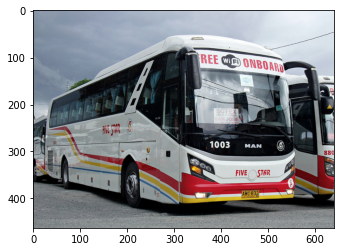

In [ ]:
start_token = tokenizer.word_index['<start>']
end_token = tokenizer.word_index['<end>']
# select random image from validation data
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0,start_token,end_token]])
caption,result,attention_weights = evaluate(image)
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)


Predicted Caption: a man riding a surfboard on a wave


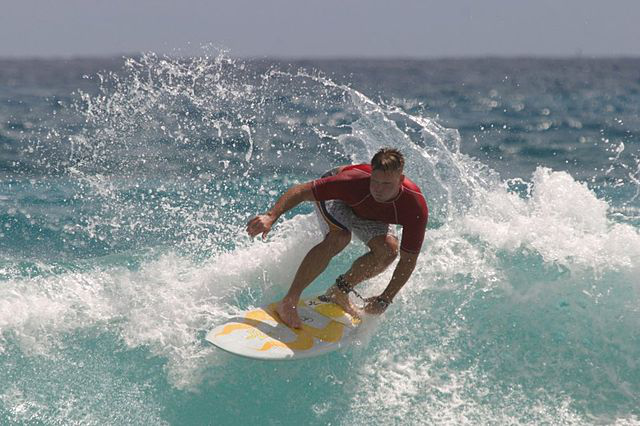

In [36]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)
result,output,attention_weights = evaluate(image_path)
print ('Predicted Caption:', ' '.join(result))
Image.open(image_path)

### Visualization

#### Deocder self attention visualization

In [96]:
def plot_attention_weights(attention, result, layer):
  fig = plt.figure(figsize=(16, 8))
 
  attention = tf.squeeze(attention[layer], axis=0)

  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1,:-1], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(result)))
    ax.set_yticks(range(len(result)))
    
    # ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        result, 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels(result, 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

block 1 of deocder layer is self attention block, `layer` is `'decoder_layer1_block1'`,`'decoder_layer12_block1'` and so on ..

change layer to visualize plot for different layers

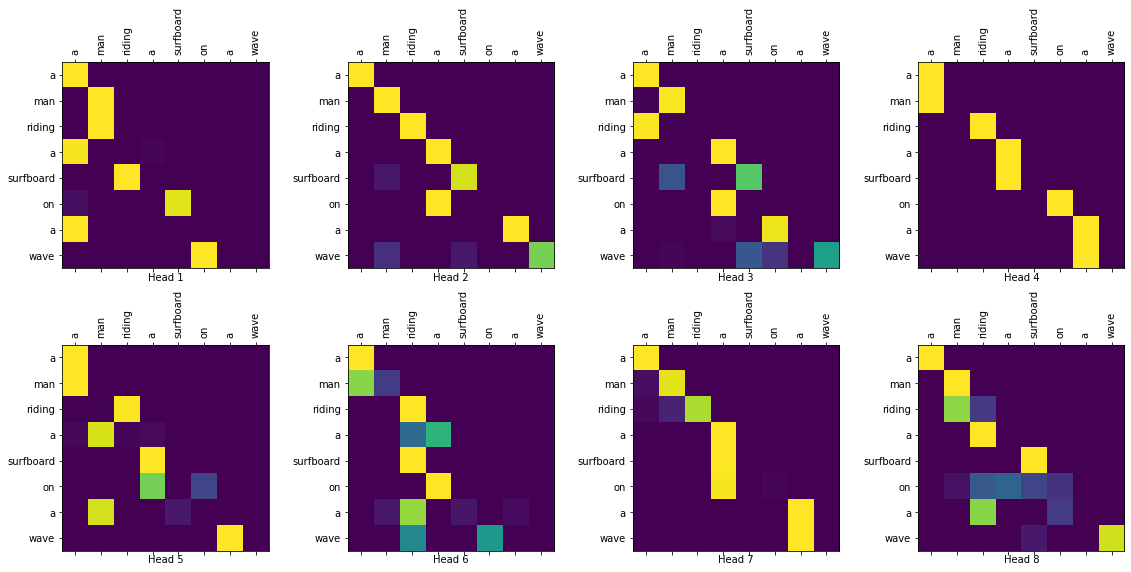

In [97]:
plot_attention_weights(attention_weights,result,layer='decoder_layer4_block1')

#### visualizing caption and image attention layers

In [98]:
def plot_attention_image(image, result, attention_plot,layer,head):
    temp_image = np.array(Image.open(image))
    
    fig = plt.figure(figsize=(10, 10))
    attention = tf.squeeze(attention_plot[layer],axis=0)
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention[head][l+1], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
        ax.axis('off')
    plt.tight_layout()
    plt.show()

block 2 of decoder is encoder decoder attention block,`layer` is `'decoder_layer1_block2'`,`'decoder_layer12_block2'` and so on ..

there is 8 attention head so plot is for each head and layer,change head and layer value for different plots

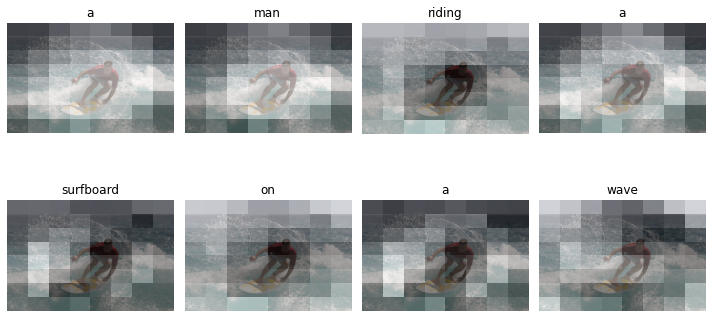

In [99]:
plot_attention_image(image_path,result,attention_weights,layer='decoder_layer4_block2',head=7)